In [1]:
import pandas as pd
import numpy as np
import pyreadstat

from docx import Document
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist, ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import dowhy
from dowhy import CausalModel
import networkx as nx
from pgmpy.estimators import PC

from collections import Counter
import os


/home/kprasath/anaconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [3]:
# Function to read a single text file
def read_txt(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        text = file.read()
    return text

# Function to read all text files in a directory
def read_all_txt_files(directory):
    file_texts = {}
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            file_id = filename.split('.')[0]
            file_path = os.path.join(directory, filename)
            file_texts[file_id] = read_txt(file_path)
    return file_texts

# Reading the Stata file
df, meta = pyreadstat.read_dta('rs_netsales.dta')

# Further selection and copying
selected_features = [
    'royaltyrate', 'tier', 'sic', 'duration', 'territory',
    'naics1', 'template', 'year', 'worldwide', 'market_gdp', 'ref'  # Adding 'ref' here
]
df_model1 = df[selected_features].copy()

In [4]:
%%time

# Read text files from all directories
directories = ['/home/kprasath/DS/NLPInternship/txt_data/ref_1_txt',
               '/home/kprasath/DS/NLPInternship/txt_data/ref_2_txt',
               '/home/kprasath/DS/NLPInternship/txt_data/ref_3_txt']

all_texts = {}
for directory in directories:
    all_texts.update(read_all_txt_files(directory))

# Match text files to DataFrame records
df_model1['contract_text'] = df_model1['ref'].apply(lambda x: all_texts.get(str(x)[1:], None))  # Removing 'L' and matching

CPU times: user 33 ms, sys: 20.6 ms, total: 53.6 ms
Wall time: 53.2 ms


In [5]:
# Using lambda function to remove 'L' and match
df_model1['contract_text'] = df_model1['ref'].apply(lambda x: all_texts.get(str(x)[1:], None))


In [6]:
df_model1.head()

,royaltyrate,tier,sic,duration,territory,naics1,template,year,worldwide,market_gdp,ref,contract_text
0,15.0,0.0,7389,1.0,China,81232,0,2007.0,0.0,3.571650,L12019,None
1,10.0,7.5,2833,20.0,Worldwide,325411,0,2011.0,1.0,72.372734,L21920,None
2,7.0,0.0,2860,99.0,Worldwide,,0,2012.0,1.0,73.673370,L25039,None
3,7.0,0.0,7389,35.0,United States,81232,1,2007.0,0.0,14.477625,L27526,None
4,1.0,0.0,3841,99.0,Unknown,339111,0,2010.0,0.0,0.000000,L21714,None


In [7]:
def filter_rows_with_text(df):
    """
    Filters out rows where the contract_text column contains None.
    
    Parameters:
        df (pandas.DataFrame): The DataFrame to filter.
        
    Returns:
        pandas.DataFrame: A new DataFrame containing only rows with text data in the contract_text column.
    """
    # Drop rows where 'contract_text' is None
    df_filtered = df.dropna(subset=['contract_text'])
    
    return df_filtered

# Usage example:
df_model1_filtered = filter_rows_with_text(df_model1)


In [8]:
df_model1_filtered.head()

,royaltyrate,tier,sic,duration,territory,naics1,template,year,worldwide,market_gdp,ref,contract_text
507,20.0,10.0,2834,20.0,Worldwide,325412,0,2006.0,1.0,50.955288,L31513,\nTop of Form\n\n\n\n\n\nType: EX-10.1 Descrip...
508,2.0,0.0,2821,20.0,Worldwide,325211,0,2006.0,1.0,50.955288,L9528,Top of Form\n\n\n Type: EX-10.63 Description:...
510,30.0,20.0,2836,20.0,Afghanistan; Bangladesh; Bhutan; Brunei; Cambo...,325414,0,2008.0,0.0,7.985790,L30380,DEVELOPMENT AND COMMERCIALIZATION AGREEMENT\n...
511,5.0,0.0,3826,20.0,Worldwide,334516,0,2008.0,1.0,63.079880,L31791,CK~~~I~If~3~~II~1~:~Illl1~~T11~u~~~~\nExhibit ...
512,2.0,0.0,3826,20.0,Worldwide,334516,0,2006.0,1.0,50.955288,L12805,Top of Form\n\n\n Type: EX-10.13 Description:...


In [9]:
# Download the stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

new_stopwords = ["all", "due", "to", "on", "daily","b"]

stop_words.update(new_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kprasath/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:


def preprocess_text(text):
    """
    Preprocesses the given text by applying tokenization, lowercasing, stopword and special character removal.
    
    Parameters:
        text (str): The text to preprocess.
        
    Returns:
        str: The preprocessed text.
    """
    # Tokenization and lowercasing
    tokens = nltk.word_tokenize(text.lower())
    
    # Stopword Removal
    tokens = [word for word in tokens if word not in stop_words]
    
    # Special Character Removal
    tokens = [re.sub(r'\W+', '', word) for word in tokens]
    
    # Removing tokens that are now empty after special character removal
    tokens = [word for word in tokens if word]
    
    return ' '.join(tokens)

# Apply text preprocessing to each contract text
df_model1_filtered['processed_text'] = df_model1_filtered['contract_text'].apply(preprocess_text)

/tmp/ipykernel_9132/1935274378.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model1_filtered['processed_text'] = df_model1_filtered['contract_text'].apply(preprocess_text)


# Dov 2 Vec

In [11]:
df_model1_filtered.head()

,royaltyrate,tier,sic,duration,territory,naics1,template,year,worldwide,market_gdp,ref,contract_text,processed_text
507,20.0,10.0,2834,20.0,Worldwide,325412,0,2006.0,1.0,50.955288,L31513,\nTop of Form\n\n\n\n\n\nType: EX-10.1 Descrip...,top form type ex101 description ex101 enanta r...
508,2.0,0.0,2821,20.0,Worldwide,325211,0,2006.0,1.0,50.955288,L9528,Top of Form\n\n\n Type: EX-10.63 Description:...,top form type ex1063 description exhibit 1063 ...
510,30.0,20.0,2836,20.0,Afghanistan; Bangladesh; Bhutan; Brunei; Cambo...,325414,0,2008.0,0.0,7.985790,L30380,DEVELOPMENT AND COMMERCIALIZATION AGREEMENT\n...,development commercialization agreement wyeth ...
511,5.0,0.0,3826,20.0,Worldwide,334516,0,2008.0,1.0,63.079880,L31791,CK~~~I~If~3~~II~1~:~Illl1~~T11~u~~~~\nExhibit ...,ckiif3ii1 illl1t11u exhibit research option ag...
512,2.0,0.0,3826,20.0,Worldwide,334516,0,2006.0,1.0,50.955288,L12805,Top of Form\n\n\n Type: EX-10.13 Description:...,top form type ex1013 description exhibit 1013 ...


<Axes: >

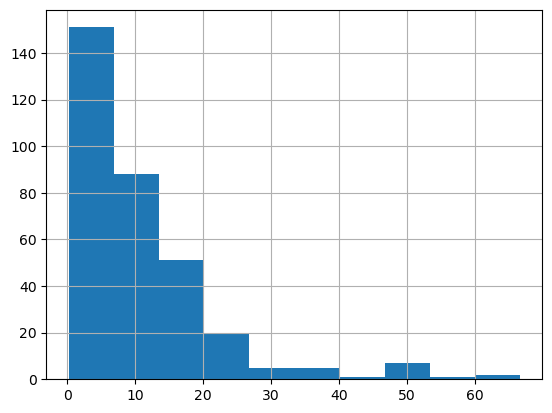

In [12]:
df_model1_filtered.royaltyrate.hist()

In [13]:
df_model1_filtered.shape

In [20]:
# Your existing code for creating TaggedDocument objects and splitting data
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(df_model1_filtered['processed_text'])]

# Split the DataFrame first
train_df, test_df = train_test_split(df_model1_filtered, test_size=0.2, random_state=42)

# Extract tagged documents
train_tagged = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train_df['processed_text'])]
test_tagged = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(test_df['processed_text'])]

# Extract labels
train_labels = train_df['royaltyrate'].values
test_labels = test_df['royaltyrate'].values

In [21]:
%%time
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(train_tagged)  # Changed from train_data to train_tagged
model.train(train_tagged, total_examples=model.corpus_count, epochs=model.epochs)  # Changed from train_data to train_tagged

CPU times: user 3min 31s, sys: 462 ms, total: 3min 32s
Wall time: 58.7 s


In [23]:
%%time

train_vectors = [model.infer_vector(doc.words) for doc in train_tagged]
test_vectors = [model.infer_vector(doc.words) for doc in test_tagged]


CPU times: user 3min 9s, sys: 694 µs, total: 3min 9s
Wall time: 3min 9s


In [27]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor()
clf.fit(train_vectors, train_labels)


RandomForestRegressor()

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on test data
preds = clf.predict(test_vectors)

# Evaluate the model
mae = mean_absolute_error(test_labels, preds)
mse = mean_squared_error(test_labels, preds)
rmse = np.sqrt(mse)
r2 = r2_score(test_labels, preds)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")


Mean Absolute Error: 7.258137313432835
Mean Squared Error: 159.93995485343282
Root Mean Squared Error: 12.646736925129455
R-squared: 0.10499358110379231


# Notes:

- PCA/PFA/VIF
- relationship contract length x royalaty
- risk